# ClimateNet AR Analysis: Precipitation

In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.patches as mpatches
import glob

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '10GiB' # PBSCluster specification
nmem2 = '10GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/GPU/proxy/{port}/status'}) # need to include name of server if named!
# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37229 instead
  warnings.warn(
Exception in callback multi_future.<locals>.callback(<Task cancell...ession.py:77>>) at /glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/tornado/gen.py:524
handle: <Handle multi_future.<locals>.callback(<Task cancell...ession.py:77>>) at /glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/tornado/gen.py:524>
Traceback (most recent call last):
  File "/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/tornado/gen.py", line 530, in callback
    result_list.append(f.result())
                       ^^^^^^^^^^
  File "/glade/work/kdagon/conda-envs/PEx_v2/lib/pytho

In [6]:
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/Casper%20CPU%20CCR/proxy/{port}/status'}) # need to include name of server if named!

In [3]:
client

<Client: 'tcp://128.117.208.115:33053' processes=0 threads=0, memory=0 B>

## Set ClimateNet filepath

In [4]:
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

## Set regional bounds

In [5]:
# Western US domain from Payne & Magnusdottir (2014,2015) papers (estimated, modified to include land at all lons)
#lat_bounds = slice(25,61)
#lon_bounds = slice(189, 250)

# Restricted western US (mostly land) domain from Collow et al. 2020
#lat_bounds = slice(32,50)
#lon_bounds = slice(235,246)

# Western US/Eastern Pacific domain from ARTMIP
lat_bounds = slice(25,65)
lon_bounds = slice(180,255)

### Preprocessing function to subset regionally

In [6]:
def preprocess_region(ds):
    # return regional domain
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

## CESM historical simulation

In [7]:
hist_yrs = [str(i) for i in range(2000,2006)]
#hist_folders = ["B20TRC5CN/"+y+"/masks/" for y in hist_yrs]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std

In [8]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
hist_paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)]
#hist_paths

### Read in masks with preprocessing

In [9]:
%%time
cnet_hist_shift = xr.open_mfdataset(hist_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 2.18 s, sys: 141 ms, total: 2.32 s
Wall time: 29.1 s


In [56]:
#cnet_hist_shift

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [10]:
timeshift = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")

In [11]:
cnet_hist = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)
#cnet_hist

## CESM RCP2.6 simulation

In [12]:
#rcp26_yrs = [str(i) for i in range(2006,2016)]
rcp26_yrs = [str(i) for i in range(2006,2015)] # for comparison to RCP8.5 14-yr climatology
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks/" for y in rcp26_yrs]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_v2/" for y in rcp26_yrs] # updated data processing (3hrly PSL)
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # unweighted means/std

In [13]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp26_paths = [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
#rcp26_paths

### Read in masks with preprocessing

In [14]:
%%time
cnet_rcp26 = xr.open_mfdataset(rcp26_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 1.66 s, sys: 140 ms, total: 1.8 s
Wall time: 21.3 s


In [64]:
#cnet_rcp26

## Combine historical/RCP2.6

In [15]:
cnet_hist_rcp26 = xr.concat([cnet_hist, cnet_rcp26], dim='time')
cnet_hist_rcp26

<xarray.DataArray 'masks' (time: 43800, lat: 170, lon: 241)>
dask.array<concatenate, shape=(43800, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2014-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## RCP8.5 simulation

In [16]:
rcp85_yrs = [str(i) for i in range(2086,2101)]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_unwgt/" for y in rcp85_yrs] # unweighted means/std
rcp85_folders = ["BRCP85C5CN/"+y+"/masks_rcp85config/" for y in rcp85_yrs] # RCP8.5 data used to calculate means/std in config file (unweighted)

In [17]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp85_paths = [cesm_cnet_filepath+rcp85_folders[i]+cnet_file for i,f in enumerate(rcp85_folders)]
#rcp85_paths

### Read in masks with preprocessing

In [18]:
%%time
cnet_rcp85 = xr.open_mfdataset(rcp85_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 2.62 s, sys: 183 ms, total: 2.8 s
Wall time: 33.7 s


In [19]:
cnet_rcp85

<xarray.DataArray 'masks' (time: 43800, lat: 170, lon: 241)>
dask.array<concatenate, shape=(43800, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    remap_script:               ncremap
    remap_version:              4.7.9
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    history_of_appended_files:  Mon Apr  3 13:13:47 2023: Appended file outpu...

## Read in landfrac for this grid
To subset land points and/or counts at coastlines

In [76]:
landfrac_file = "/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/USGS-gtopo30_ne120np4_16xdel2-PFC-consistentSGH.regrid_0.23x0.31.nc"
landfrac_ds = xr.open_dataset(landfrac_file)
landfrac = landfrac_ds.LANDFRAC.sel(lat=lat_bounds,lon=lon_bounds)
#landfrac

## Define ARs

In [20]:
AR = cnet_hist_rcp26.clip(min=1)-1
#AR

In [21]:
AR_rcp85 = cnet_rcp85.clip(min=1)-1

## Read in precipitation field 
Be VERY CAREFUL with time index here such that it matches masks (especially for RCP8.5 since those are off)

In [22]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/" # CESM historical output
cesm_rcp26_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP26C5CN/" # CESM RCP2.6 output
cesm_rcp85_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP85C5CN/" # CESM RCP8.5 output

In [23]:
# h4.PRECT (hist & RCP2.6) and and h5.PRECT (RCP8.5) is 3hrly instantaneous
# h3.PRECT is 3hrly average (all sims)

#PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT*FV.nc"
#PRECT_hist_file = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT.2000010100Z-2000123121Z.FV.nc" # testing year 2000 only
PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h3.PRECT*regrid*"

PRECT_rcp26_files = "b.e13.BRCP26C5CN.ne120_g16.003.cam.h3.*PRECT*regrid*"
#PRECT_rcp26_files = "b.e13.BRCP26C5CN.ne120_g16.003.cam.h3.20{06..14}*PRECT*regrid*" # for comparison to RCP8.5 14-yr climatology (doesn't work here...)

PRECT_rcp85_files = "b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.*PRECT*regrid*"

### Function for use of wildcards in files

In [87]:
def paths(*args):
    """ 
    Returns glob'd paths in list for arbitrary number of function arguments.
    Note, each expanded set of paths is sorted. 

    Phillip J. Wolfram
    10/25/2016
    """
    paths = []
    for aargs in args:
        paths += sorted(glob.glob(aargs))
    return paths

### Preprocessing function to return PRECT only
with option to subset spatially (save memory)

In [24]:
def preprocess_PRECT(ds):
    #return ds['PRECT']
    return ds['PRECT'].sel(lat=lat_bounds,lon=lon_bounds)

### Read in PRECT files

In [25]:
%%time
PRECT_hist_shift = xr.open_mfdataset(cesm_hist_filepath+PRECT_hist_files, concat_dim='time', combine="nested", chunks={'time':800}, parallel=True, preprocess=preprocess_PRECT)
#PRECT_hist_shift = xr.open_dataset(cesm_hist_filepath+PRECT_hist_file, chunks={'time':500,'lat':100,'lon':200})

CPU times: user 1.08 s, sys: 70.4 ms, total: 1.15 s
Wall time: 14.4 s


In [77]:
#PRECT_hist_shift

### Timeshift historical output
Use the same timeshift calculated for masks

In [26]:
PRECT_hist = PRECT_hist_shift.assign_coords(time=timeshift)
#PRECT_hist

### RCP2.6

In [27]:
%%time
PRECT_rcp26 = xr.open_mfdataset(cesm_rcp26_filepath+PRECT_rcp26_files, concat_dim='time', combine="nested", chunks={'time':800}, parallel=True, preprocess=preprocess_PRECT)
#PRECT_rcp26

CPU times: user 1.39 s, sys: 103 ms, total: 1.49 s
Wall time: 18.2 s


### Concat hist/rcp26 PRECT

In [28]:
#PRECT_hist_rcp26 = xr.concat([PRECT_hist, PRECT_rcp26], dim='time')
PRECT_hist_rcp26 = xr.concat([PRECT_hist, PRECT_rcp26.sel(time=slice('2006','2014'))], dim='time') # for comparison to RCP8.5 14-yr climatology
PRECT_hist_rcp26

<xarray.DataArray 'PRECT' (time: 43800, lat: 170, lon: 241)>
dask.array<concatenate, shape=(43800, 170, 241), dtype=float32, chunksize=(800, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * time     (time) object 2000-01-01 00:00:00 ... 2014-12-31 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

### RCP8.5

In [29]:
%%time
PRECT_rcp85 = xr.open_mfdataset(cesm_rcp85_filepath+PRECT_rcp85_files, concat_dim='time', combine="nested", chunks={'time':800}, parallel=True, preprocess=preprocess_PRECT)
#PRECT_rcp85

CPU times: user 336 ms, sys: 2.12 ms, total: 338 ms
Wall time: 839 ms


## Calculate fraction of total precipitation associated with an AR

In [30]:
def calc_prect_AR(PRECT, AR):

    # precipitation overlapping with AR
    PRECT_AR = PRECT.where(AR==1).sum(dim='time')
    
    # total precipitation
    PRECT_sum = PRECT.sum(dim='time')
    
    # proportion of precip overlapping with AR
    PRECT_AR_frac = 100*(PRECT_AR/PRECT_sum)
    
    # seasonal breakdown
    PRECT_AR_byseason = PRECT.where(AR==1).groupby("time.season").sum(dim='time')
    PRECT_sum_byseason = PRECT.groupby("time.season").sum(dim='time')
    PRECT_AR_frac_byseason = 100*(PRECT_AR_byseason/PRECT_sum_byseason)
    
    # return annual total and by season
    return(PRECT_AR_frac, PRECT_AR_frac_byseason)

In [31]:
# return seasonal values for plots
PRECT_AR_frac, PRECT_AR_frac_byseason = calc_prect_AR(PRECT_hist_rcp26, AR)
PRECT_AR_frac_rcp85, PRECT_AR_frac_byseason_rcp85 = calc_prect_AR(PRECT_rcp85, AR_rcp85)

In [37]:
PRECT_AR_frac

<xarray.DataArray 'PRECT' (lat: 170, lon: 241)>
dask.array<mul, shape=(170, 241), dtype=float32, chunksize=(170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0

### NOTE: make sure you have enough memory for these steps

In [32]:
PRECT_AR_frac_byseason = PRECT_AR_frac_byseason.persist()

In [33]:
print(PRECT_AR_frac_byseason.max().values)

83.02949


### Seasonal spatial plots

/glade/derecho/scratch/kdagon/tmp/ipykernel_9048/2598369822.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Greens', 16)


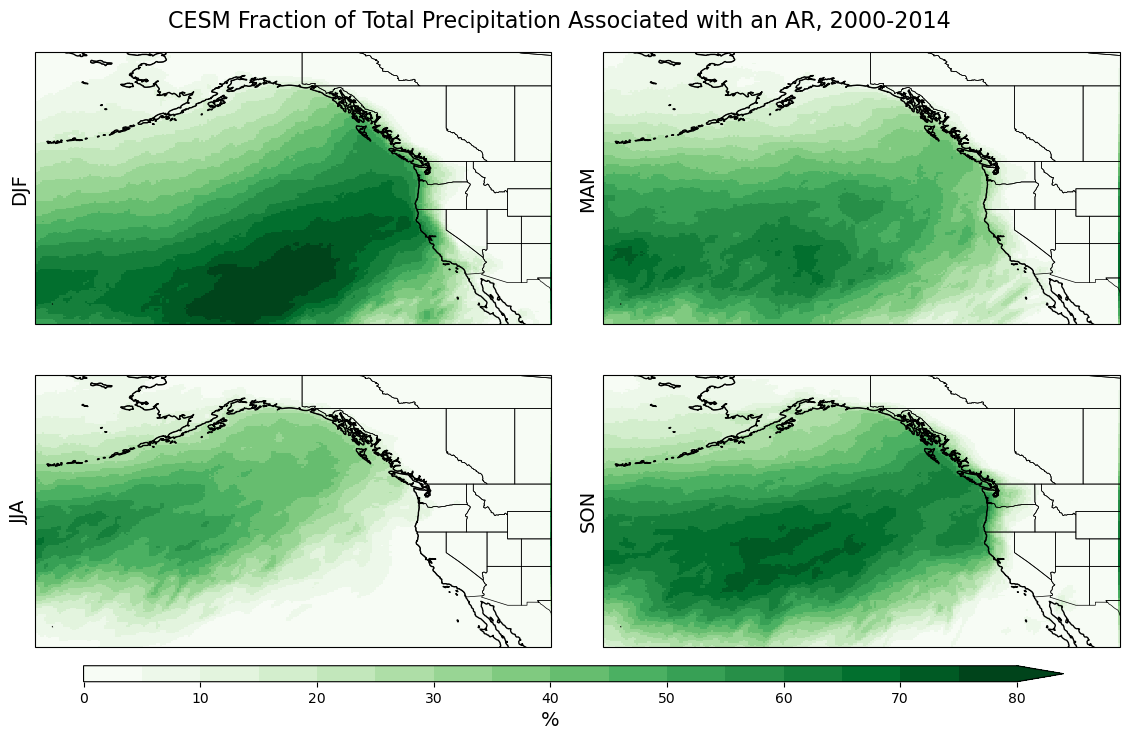

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 16)
vmax = 80

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(PRECT_AR_frac_byseason.sel(season=season), coord=PRECT_AR_frac_byseason.lon)
    lat = PRECT_AR_frac_byseason.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
#cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb.ax.set_xlabel('%', fontsize=14)

# add title
#fig.suptitle('CESM Fraction of Total Precipitation Associated with an AR, 2000-2005', fontsize=16, y=0.92)
fig.suptitle('CESM Fraction of Total Precipitation Associated with an AR, 2000-2014', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/PRECT_AR_WUS_CESM_hist_rcp26_byseason.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PRECT_AR_WUS_CESM_hist_rcp26_byseason_unwgt.png', bbox_inches='tight')

### RCP8.5

In [34]:
PRECT_AR_frac_byseason_rcp85 = PRECT_AR_frac_byseason_rcp85.persist()

In [35]:
print(PRECT_AR_frac_byseason_rcp85.max().values)

74.92121


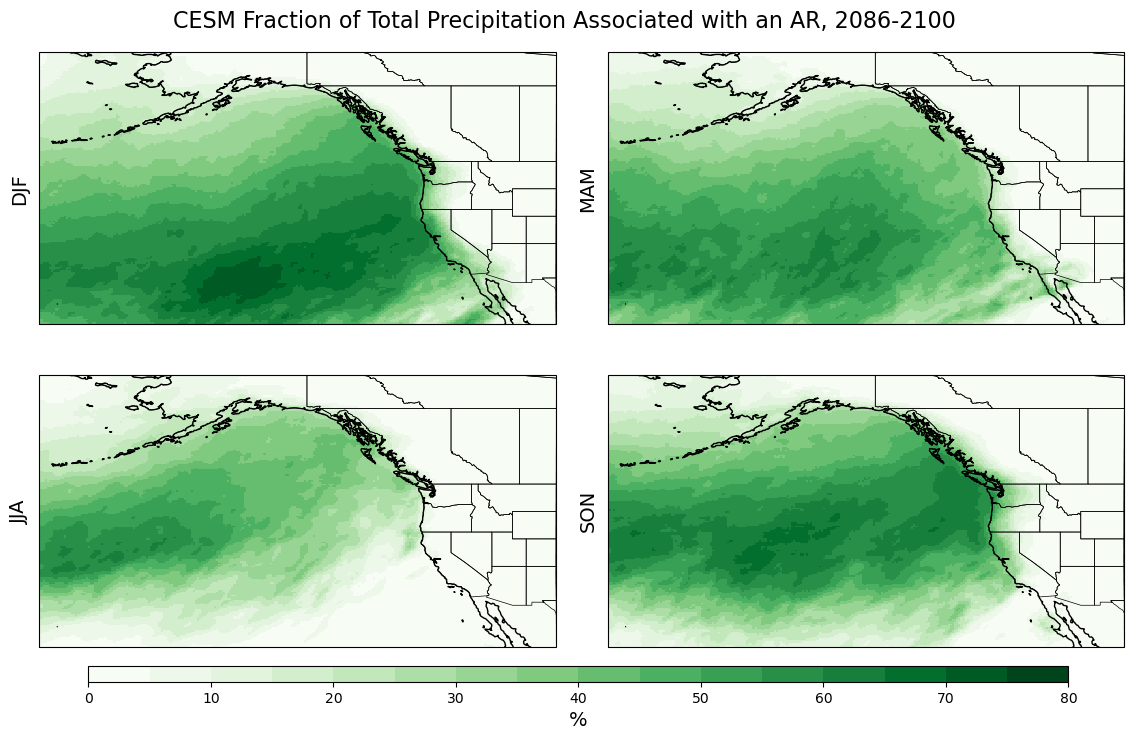

In [249]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 16)
vmax = 80

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(PRECT_AR_frac_byseason_rcp85.sel(season=season), coord=PRECT_AR_frac_byseason_rcp85.lon)
    lat = PRECT_AR_frac_byseason_rcp85.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal')
#cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('CESM Fraction of Total Precipitation Associated with an AR, 2086-2100', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/PRECT_AR_WUS_CESM_rcp85_byseason_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PRECT_AR_WUS_CESM_rcp85_byseason_unwgt_config.png', bbox_inches='tight')

### Diff

In [36]:
PRECT_AR_frac_byseason_diff = PRECT_AR_frac_byseason_rcp85 - PRECT_AR_frac_byseason
print(PRECT_AR_frac_byseason_diff.min().values, PRECT_AR_frac_byseason_diff.max().values)

-32.470043 40.054863


/glade/derecho/scratch/kdagon/tmp/ipykernel_25180/2500212057.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


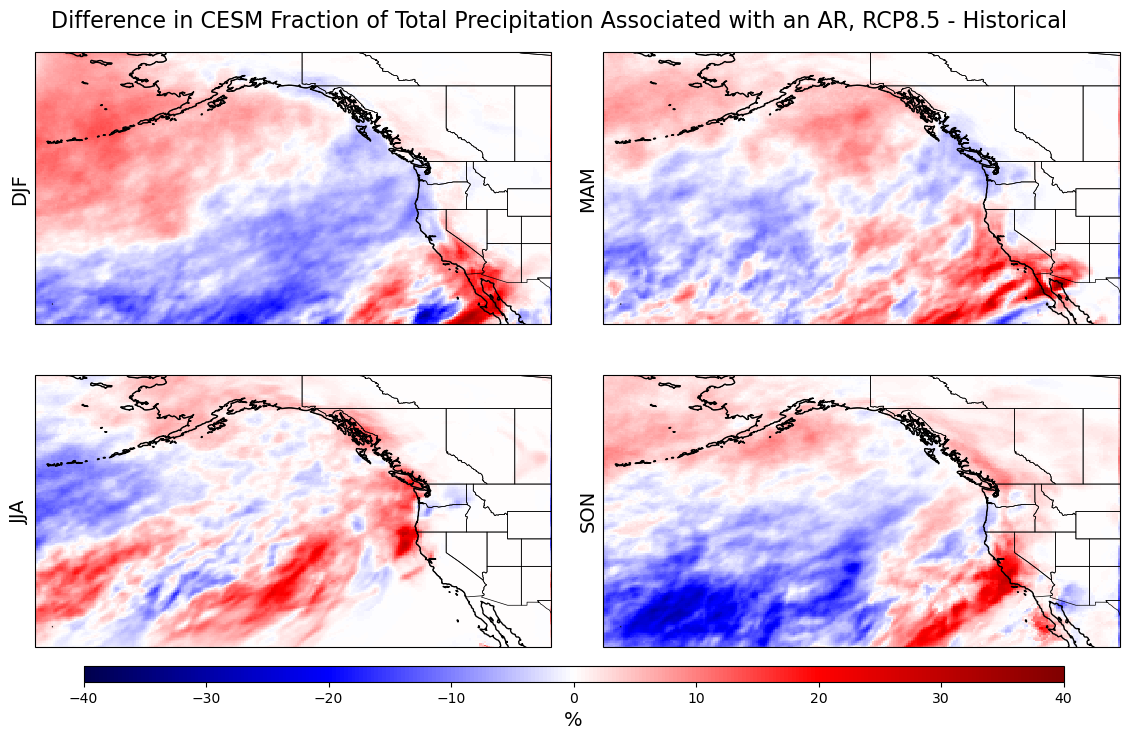

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('seismic')
vmin = -40
vmax = 40

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(PRECT_AR_frac_byseason_diff.sel(season=season), coord=PRECT_AR_frac_byseason_diff.lon)
    lat = PRECT_AR_frac_byseason_diff.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal')
#cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('Difference in CESM Fraction of Total Precipitation Associated with an AR, RCP8.5 - Historical', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/PRECT_AR_WUS_CESM_diff_byseason_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PRECT_AR_WUS_CESM_diff_byseason_unwgt_config.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PRECT_AR_WUS_CESM_diff_byseason_unwgt_config_v2.png', dpi=600, bbox_inches='tight')

Some interesting seasonal results in the diff plots...e.g., increases in DJF, MAM and SON over SW US

### Panel plot with seasonal fractions and diffs
Make sure to use `pcolormesh` instead of `pcolor` - so much faster!

/glade/derecho/scratch/kdagon/tmp/ipykernel_9048/282073279.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Greens', 16)
/glade/derecho/scratch/kdagon/tmp/ipykernel_9048/282073279.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap('seismic')


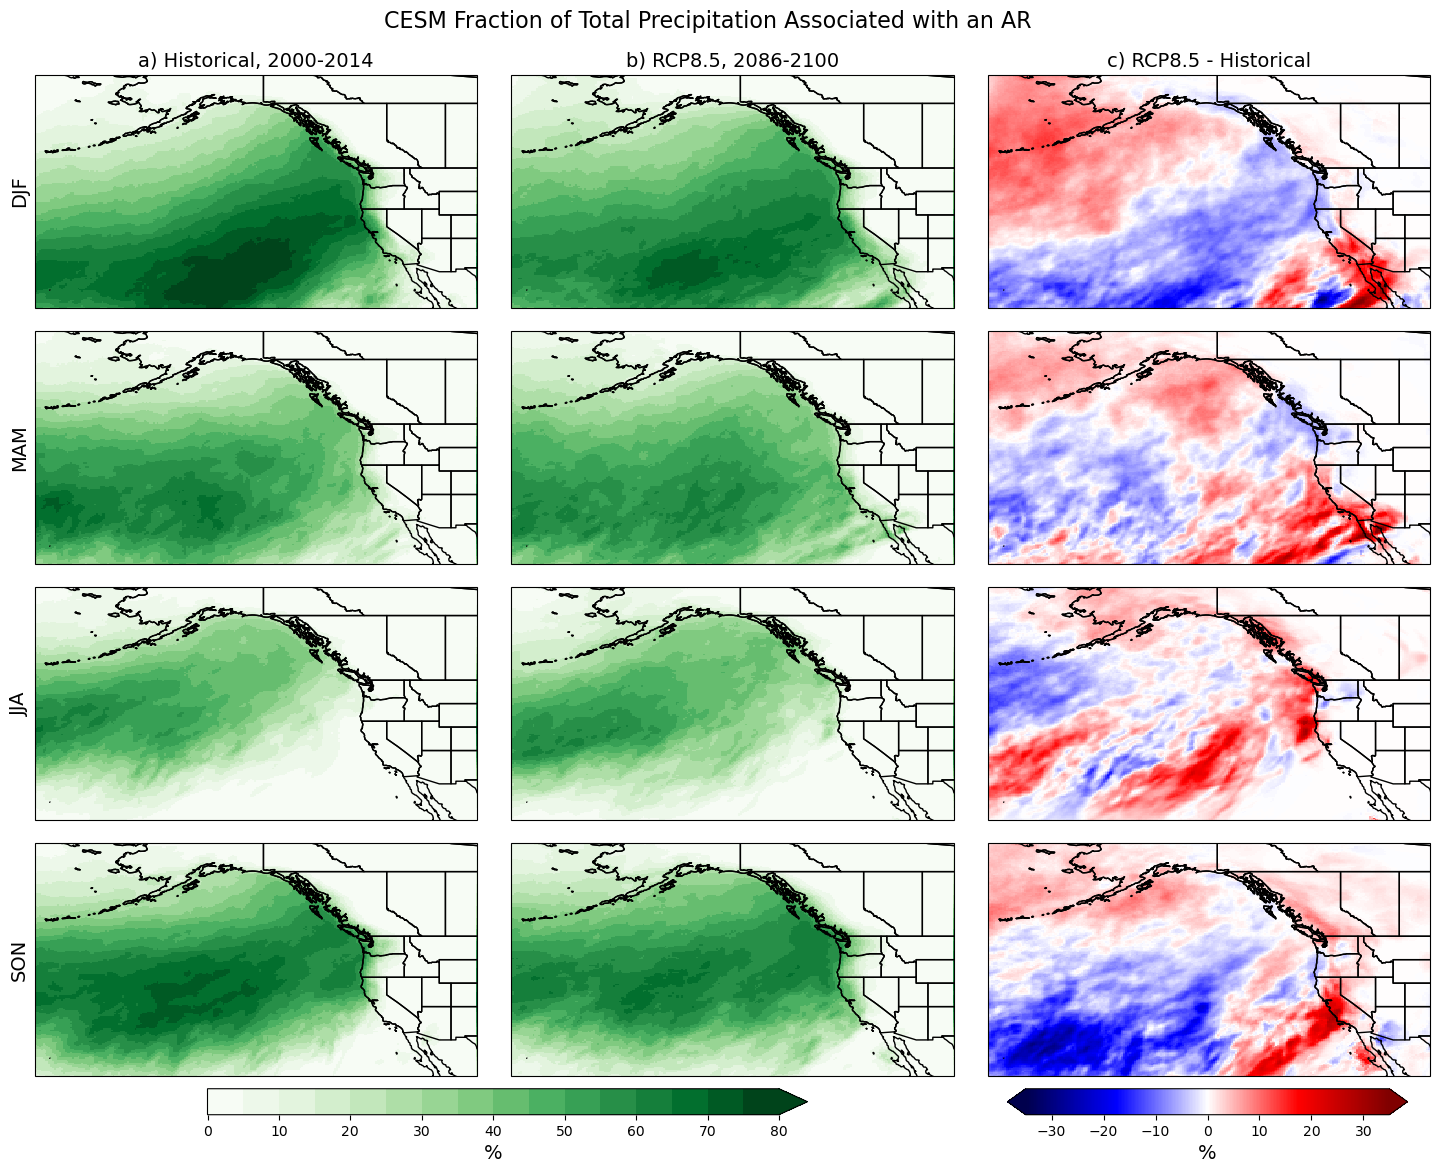

In [60]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 16)
vmax = 80

# try changing the hatch color
#plt.rcParams.update({'hatch.color': 'k'})

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(PRECT_AR_frac_byseason.sel(season=season), coord=PRECT_AR_frac_byseason.lon)
    lat = PRECT_AR_frac_byseason.lat
    cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.STATES, zorder=2)
    # optionally add greyed out ocean
    #axs[i,0].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])
    axs[i,0].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(PRECT_AR_frac_byseason_rcp85.sel(season=season), coord=PRECT_AR_frac_byseason_rcp85.lon)
    lat = PRECT_AR_frac_byseason_rcp85.lat
    cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.STATES, zorder=2)
    #axs[i,1].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,1].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.25, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb1.ax.set_xlabel('%', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-35
vmax2=35

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('c) RCP8.5 - Historical', fontsize=14)
    # significance hatching - need to do this first or plots get cut off
    #lon = PRECT_AR_frac_byseason_diff.lon # need to use original lon (add_cyclic_point adds to the lon dimension)
    #lat = PRECT_AR_frac_byseason_diff.lat
    # need to calculate these quantiles if I want to use significance hatching here
    #axs[i,2].contourf(lon, lat, xr.where((
    #    PRECT_AR_frac_byseason_diff.sel(season=season) <= PRECT_AR_frac_quantiles.sel(season=season, quantile=0.025)) | (
    #    PRECT_AR_frac_byseason_diff.sel(season=season) >= PRECT_AR_frac_quantiles.sel(season=season, quantile=0.975)),
    #    1.0, np.nan).data, 
    #    transform=ccrs.PlateCarree(),
    #    colors='none', levels=[1.0, 1.5],
    #    #hatches=['////'], #another hatch option
    #    hatches=['XXX'],
    #    zorder=10)
    field, lon = add_cyclic_point(PRECT_AR_frac_byseason_diff.sel(season=season), coord=PRECT_AR_frac_byseason_diff.lon)
    lat = PRECT_AR_frac_byseason_diff.lat
    cf = axs[i,2].pcolormesh(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.STATES, zorder=2)
    #axs[i,2].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,2].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# colorbar for diff plots
cb2_ax = fig.add_axes([0.65, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('%', fontsize=14)    
    
# add title
fig.suptitle('CESM Fraction of Total Precipitation Associated with an AR', fontsize=16, y=0.93)

plt.subplots_adjust(wspace=-0.2, hspace=0.1)

#plt.savefig('../figures/toSCP/PRECT_AR_frac_WUS_hist_rcp_diff_byseason.png', bbox_inches='tight', dpi=300)

### Climatological Line Plots

In [252]:
def calc_prect_AR_time(PRECT, AR):

    # precipitation overlapping with AR
    PRECT_AR = PRECT.where(AR==1).sum(dim=('lat','lon'))
    
    # total precipitation
    PRECT_sum = PRECT.sum(dim=('lat','lon'))
    
    # proportion of precip overlapping with AR
    PRECT_AR_frac = 100*(PRECT_AR/PRECT_sum)
    
    # return annual total and by season
    return(PRECT_AR_frac)

In [253]:
PRECT_AR_frac_time = calc_prect_AR_time(PRECT_hist_rcp26, AR)
PRECT_AR_frac_time_rcp85 = calc_prect_AR_time(PRECT_rcp85, AR_rcp85)

In [254]:
PRECT_AR_frac_time 

<xarray.DataArray 'PRECT' (time: 46720)>
dask.array<mul, shape=(46720,), dtype=float32, chunksize=(500,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00

In [255]:
# mean by month of year
PRECT_AR_frac_time_monthofyear = PRECT_AR_frac_time.groupby("time.month").mean().persist()
# standard deviation
PRECT_AR_frac_time_monthofyear_std = PRECT_AR_frac_time.groupby("time.month").std().persist()

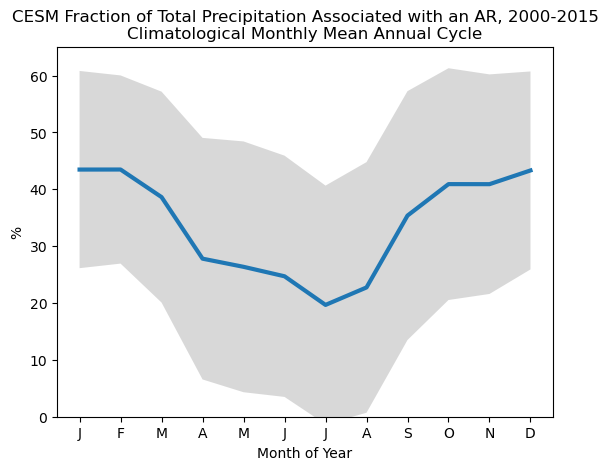

In [95]:
# with fill for standard deviation
plt.plot(PRECT_AR_frac_time_monthofyear.month, PRECT_AR_frac_time_monthofyear, linewidth=3)
plt.fill_between(PRECT_AR_frac_time_monthofyear.month, PRECT_AR_frac_time_monthofyear-PRECT_AR_frac_time_monthofyear_std, 
                PRECT_AR_frac_time_monthofyear+PRECT_AR_frac_time_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.ylim([0,65])
#plt.title('Percent PEx gridpoints associated with AR, 2000-2005\nClimatological Monthly Mean Annual Cycle');
#plt.title('Fraction precipitation associated with AR, 2000-2005\nClimatological Monthly Mean Annual Cycle');
plt.title('CESM Fraction of Total Precipitation Associated with an AR, 2000-2015\nClimatological Monthly Mean Annual Cycle');

#plt.savefig('../figures/toSCP/PRECT_AR_monthofyear_withstdev_WUS_CESM_hist_rcp26_unwgt.png', bbox_inches='tight')

In [37]:
# mean by time of day
PRECT_AR_frac_time_timeofday = PRECT_AR_frac_time.groupby("time.hour").mean().persist()
# standard deviation
PRECT_AR_frac_time_timeofday_std = PRECT_AR_frac_time.groupby("time.hour").std().persist()

In [38]:
# 3hrly frequency
PRECT_AR_frac_time_timeofday.hour

<xarray.DataArray 'hour' (hour: 8)>
array([ 0,  3,  6,  9, 12, 15, 18, 21])
Coordinates:
  * hour     (hour) int64 0 3 6 9 12 15 18 21

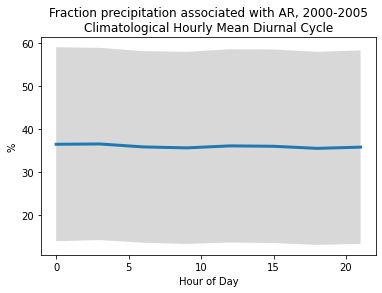

In [39]:
plt.plot(PRECT_AR_frac_time_timeofday.hour, PRECT_AR_frac_time_timeofday, linewidth=3)
plt.fill_between(PRECT_AR_frac_time_timeofday.hour, PRECT_AR_frac_time_timeofday-PRECT_AR_frac_time_timeofday_std, 
                PRECT_AR_frac_time_timeofday+PRECT_AR_frac_time_timeofday_std, alpha=0.3, facecolor='grey')
plt.xlabel('Hour of Day')
plt.ylabel('%')
#plt.ylim([0,30]) # withstdev
plt.title('Fraction precipitation associated with AR, 2000-2015\nClimatological Hourly Mean Diurnal Cycle');

In [256]:
# mean by month of year
PRECT_AR_frac_time_monthofyear_rcp85 = PRECT_AR_frac_time_rcp85.groupby("time.month").mean().persist()
# standard deviation
PRECT_AR_frac_time_monthofyear_std_rcp85 = PRECT_AR_frac_time_rcp85.groupby("time.month").std().persist()

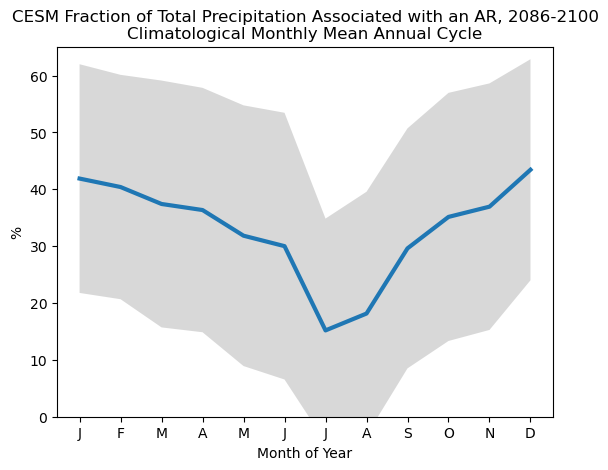

In [98]:
# with fill for standard deviation
plt.plot(PRECT_AR_frac_time_monthofyear_rcp85.month, PRECT_AR_frac_time_monthofyear_rcp85, linewidth=3)
plt.fill_between(PRECT_AR_frac_time_monthofyear_rcp85.month, PRECT_AR_frac_time_monthofyear_rcp85-PRECT_AR_frac_time_monthofyear_std_rcp85, 
                PRECT_AR_frac_time_monthofyear_rcp85+PRECT_AR_frac_time_monthofyear_std_rcp85, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.ylim([0,65])
plt.title('CESM Fraction of Total Precipitation Associated with an AR, 2086-2100\nClimatological Monthly Mean Annual Cycle');

#plt.savefig('../figures/toSCP/PRECT_AR_monthofyear_withstdev_WUS_CESM_hist_rcp85_unwgt.png', bbox_inches='tight')

In [257]:
# differences (TO DO: think about how std works here)
PRECT_AR_frac_time_monthofyear_diff = PRECT_AR_frac_time_monthofyear_rcp85 - PRECT_AR_frac_time_monthofyear

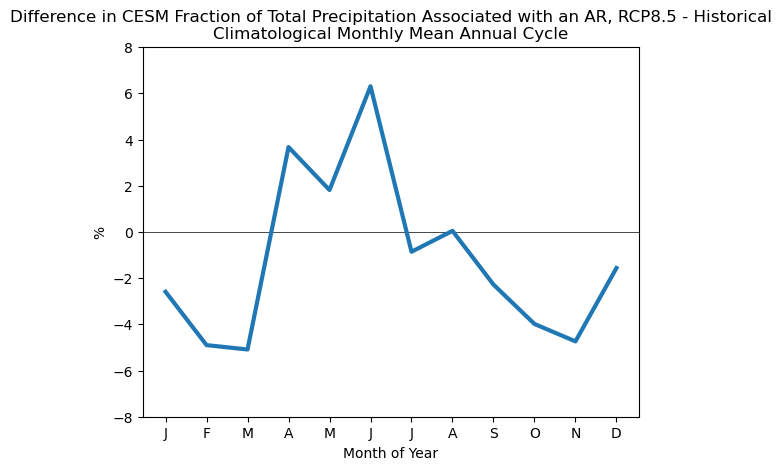

In [259]:
plt.plot(PRECT_AR_frac_time_monthofyear_diff.month, PRECT_AR_frac_time_monthofyear_diff, linewidth=3, zorder=10)
#plt.fill_between(PRECT_AR_frac_time_monthofyear_rcp85.month, PRECT_AR_frac_time_monthofyear_rcp85-PRECT_AR_frac_time_monthofyear_std_rcp85, 
#                PRECT_AR_frac_time_monthofyear_rcp85+PRECT_AR_frac_time_monthofyear_std_rcp85, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.ylim([-8,8])
plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=0.5)
plt.title('Difference in CESM Fraction of Total Precipitation Associated with an AR, RCP8.5 - Historical\nClimatological Monthly Mean Annual Cycle');

#plt.savefig('../figures/toSCP/PRECT_AR_monthofyear_WUS_CESM_diff_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PRECT_AR_monthofyear_WUS_CESM_diff_unwgt_config.png', bbox_inches='tight')

## Process extreme precipitation for a given data array and percentile

Chunking in lat/lon helps with single time chunk, though still get some performance warnings\
Other approaches could include increasing requested memory for dask workers, or doing the quantile calculation first and saving out the values to read them in and then calculate PEx

In [84]:
def process_PEx(PRECT, landfrac, percentile):
         
    # subset for land only (optional; comment out to use whole domain)
    PRECT = PRECT.where(landfrac > 0)
    
    quantile = percentile/100
    
    # PEx over time
    pX = PRECT.chunk({'time': -1, 'lat': 20, 'lon': 40}).quantile(quantile, dim='time')
    PEx = PRECT.where(PRECT > pX)
    
    # PEx by season
    pX_season = PRECT.chunk({'time': -1, 'lat': 20, 'lon': 40}).groupby("time.season").quantile(quantile, dim='time')
    PEx_season = PRECT.groupby("time.season").where(PRECT.groupby("time.season") > pX_season)
    
    return(PEx, PEx_season)

In [85]:
%%time
percentile=90
PEx, PEx_season = process_PEx(PRECT_hist_rcp26, landfrac, percentile)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 60
  result = blockwise(
/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 16 times more chunks
  return self.array[key]


CPU times: user 1.03 s, sys: 16.2 ms, total: 1.05 s
Wall time: 1.15 s


## Process extreme precipitation for a given data array and percentile, using a specific baseline
Use this function for `PEx_rcp85`

In [86]:
def process_PEx_base(PRECT, PRECT_base, landfrac, percentile):
            
    # subset for land only (optional; comment out to use whole domain)
    PRECT = PRECT.where(landfrac > 0)
    PRECT_base = PRECT_base.where(landfrac > 0)

    quantile = percentile/100
    
    # PEx over time
    pX = PRECT_base.chunk({'time': -1, 'lat': 20, 'lon': 40}).quantile(quantile, dim='time') # use the baseline file to define the percentile
    PEx = PRECT.where(PRECT > pX)
    
    # PEx by season
    pX_season = PRECT_base.chunk({'time': -1, 'lat': 20, 'lon': 40}).groupby("time.season").quantile(quantile, dim='time')
    PEx_season = PRECT.groupby("time.season").where(PRECT.groupby("time.season") > pX_season)

    return(PEx, PEx_season)

In [87]:
PEx_rcp85, PEx_season_rcp85 = process_PEx_base(PRECT_rcp85, PRECT_hist_rcp26, landfrac, percentile)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 60
  result = blockwise(
/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 16 times more chunks
  return self.array[key]


## Calculate fraction of extreme precipitation associated with an AR
### Also return total extreme precipitation
Note for processing global files: Memory can be an issue unless subsetting a specific region.\
Possible solutions could include launching jupyter on compute node for >4GB memory and/or modify client memory and workflow to reduce data sizes.

In [88]:
def calc_overlap(AR,PEx,PEx_season):
    
    # Compute sum of extreme precipitation amount over time at each gridpoint
    PEx_sum = PEx.sum(dim='time')
    # subset for land only (optional; comment out to use whole domain)
    PEx_sum = PEx_sum.where(landfrac > 0)

    # By season
    PEx_sum_byseason = PEx_season.groupby("time.season").sum(dim='time')
    PEx_sum_byseason = PEx_sum_byseason.where(landfrac > 0)
      
    # PEx overlapping with AR, sum over time
    PEx_AR = PEx.where(AR==1).sum(dim='time')
    PEx_AR_byseason = PEx_season.where(AR==1).groupby("time.season").sum(dim='time')
    
    PEx_AR_frac = 100*(PEx_AR/PEx_sum)
    PEx_AR_frac_byseason = 100*(PEx_AR_byseason/PEx_sum_byseason)
    
    return(PEx_AR_frac, PEx_AR_frac_byseason, PEx_sum, PEx_sum_byseason)

In [89]:
PEx_AR_frac, PEx_AR_frac_byseason, PEx_sum, PEx_sum_byseason = calc_overlap(AR, PEx, PEx_season)
PEx_AR_frac_rcp85, PEx_AR_frac_byseason_rcp85, PEx_sum_rcp85, PEx_sum_byseason_rcp85 = calc_overlap(AR_rcp85, PEx_rcp85, PEx_season_rcp85)

2023-04-06 16:58:36,966 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x2abe1f687790>>
Traceback (most recent call last):
  File "/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/bokeh/server/tornado.py", line 778, in _keep_alive
    c.send_ping()
  File "/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/bokeh/server/connection.py", line 93, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/tornado/websocket.py", line 445, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError


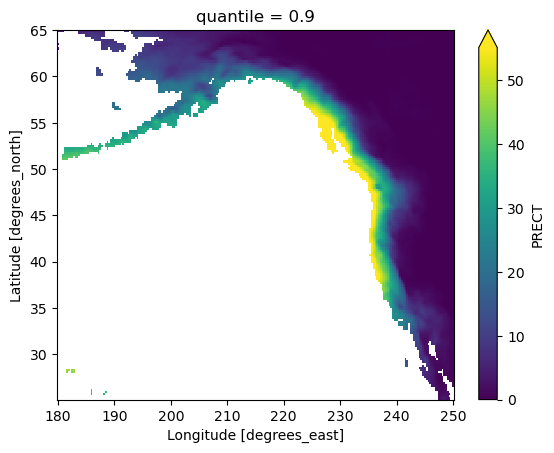

In [73]:
PEx_AR_frac.plot(robust=True);

In [90]:
%%time
PEx_AR_frac_byseason = PEx_AR_frac_byseason.persist()
print(PEx_AR_frac_byseason.max().values)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


79.43471
CPU times: user 1min 6s, sys: 1.34 s, total: 1min 7s
Wall time: 1min 59s


### Seasonal spatial plots
This plot takes a while, despite the persist commands above

/glade/derecho/scratch/kdagon/tmp/ipykernel_9048/3900151676.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Greens', 16)


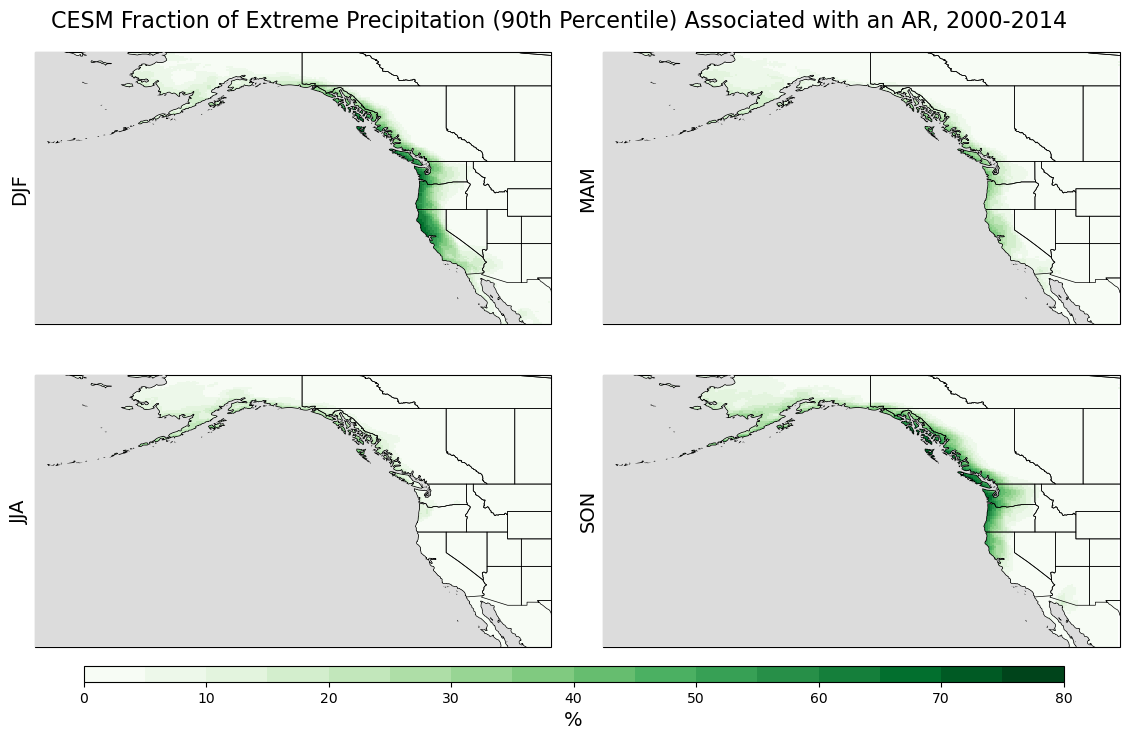

In [91]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 16)
vmax = 80

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(PEx_AR_frac_byseason.sel(season=season), coord=PEx_AR_frac_byseason.lon)
    lat = PEx_AR_frac_byseason.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal')
#cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb.ax.set_xlabel('%', fontsize=14)

# add title
#fig.suptitle('CESM Fraction of Extreme Precipitation (90th Percentile) Associated with an AR, 2000-2005', fontsize=16, y=0.92)
fig.suptitle('CESM Fraction of Extreme Precipitation (90th Percentile) Associated with an AR, 2000-2014', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/PEx90_AR_WUS_CESM_hist_byseason.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PEx90_AR_WUS_CESM_hist_rcp26_byseason.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PEx90_AR_WUS_CESM_hist_rcp26_byseason_unwgt.png', bbox_inches='tight')

In [112]:
PEx_AR_frac_byseason_rcp85

<xarray.DataArray 'PRECT' (season: 4, lat: 170, lon: 241)>
dask.array<mul, shape=(4, 170, 241), dtype=float32, chunksize=(1, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [92]:
%%time
PEx_AR_frac_byseason_rcp85 = PEx_AR_frac_byseason_rcp85.persist()
print(PEx_AR_frac_byseason_rcp85.max().values)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


77.174805
CPU times: user 1min 18s, sys: 1.81 s, total: 1min 20s
Wall time: 2min 37s


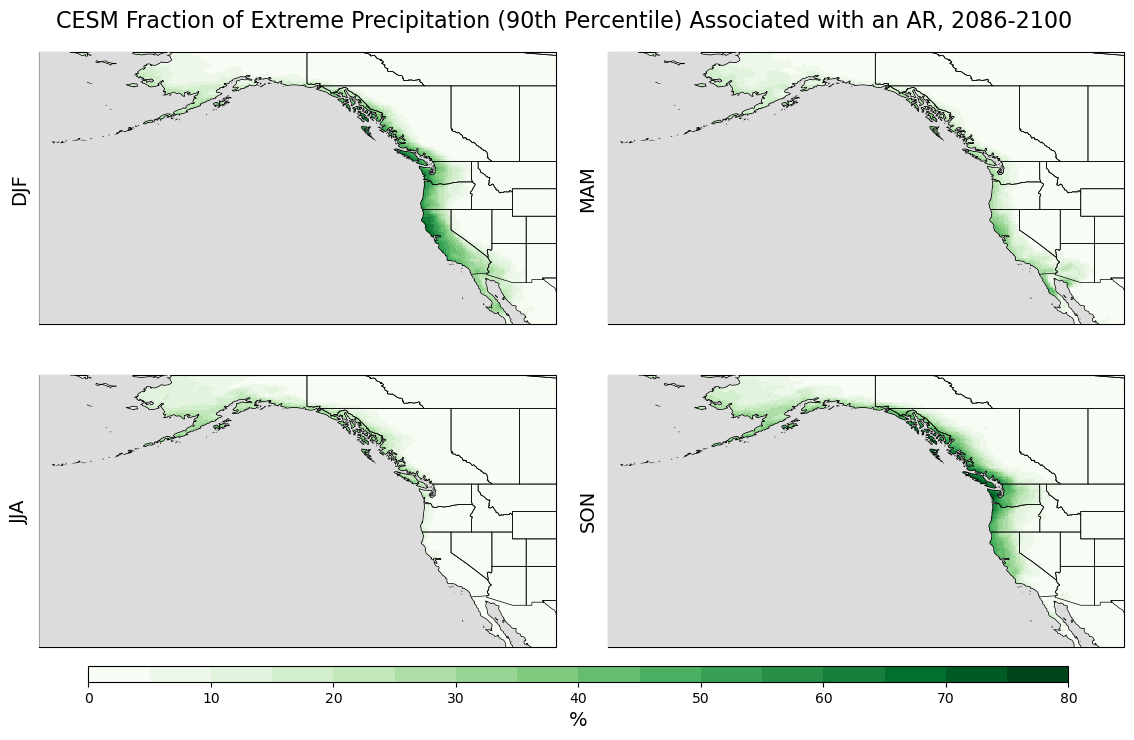

In [271]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 16)
vmax = 80

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(PEx_AR_frac_byseason_rcp85.sel(season=season), coord=PEx_AR_frac_byseason_rcp85.lon)
    lat = PEx_AR_frac_byseason_rcp85.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal')
#cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('CESM Fraction of Extreme Precipitation (90th Percentile) Associated with an AR, 2086-2100', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/PEx90_AR_WUS_CESM_rcp85_byseason_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PEx90_AR_WUS_CESM_rcp85_byseason_unwgt_config.png', bbox_inches='tight')

In [93]:
PEx_AR_frac_byseason_diff = PEx_AR_frac_byseason_rcp85 - PEx_AR_frac_byseason
print(PEx_AR_frac_byseason_diff.min().values, PEx_AR_frac_byseason_diff.max().values)

-25.712742 40.501564


/glade/derecho/scratch/kdagon/tmp/ipykernel_9048/461630350.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


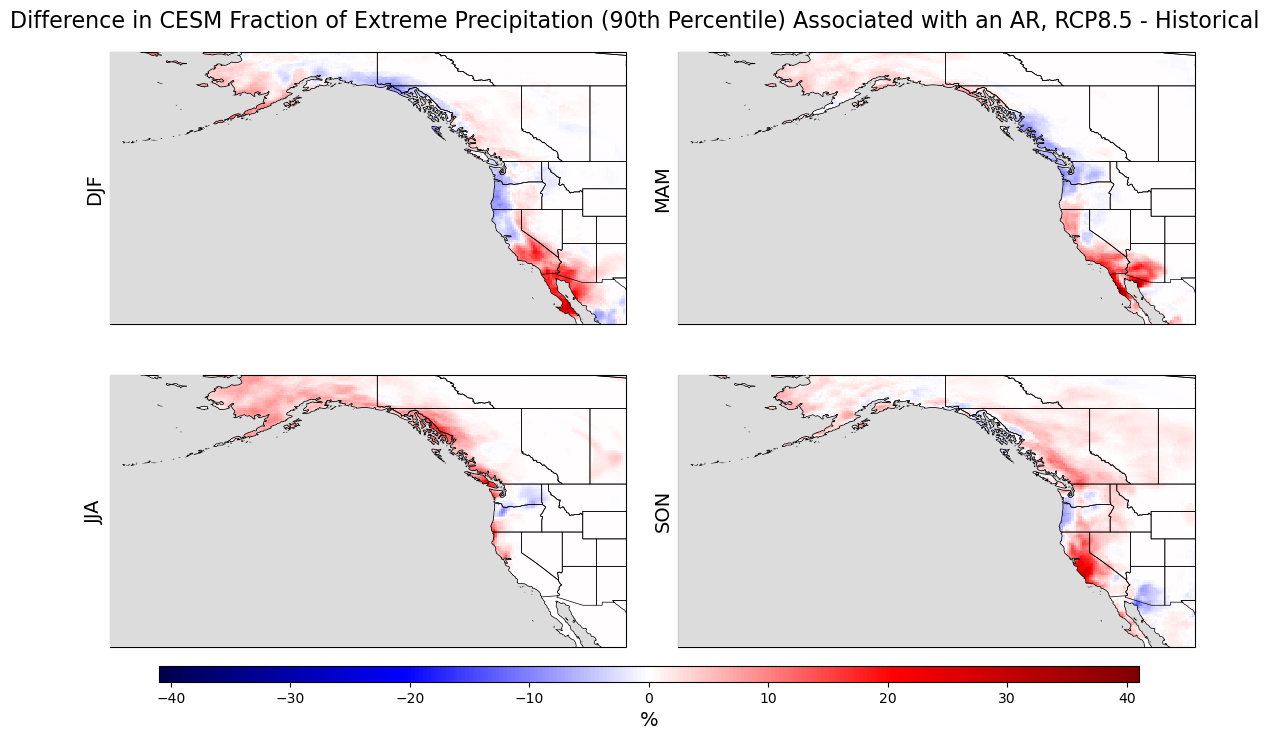

In [94]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('seismic')
vmin = -41
vmax = 41

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(PEx_AR_frac_byseason_diff.sel(season=season), coord=PEx_AR_frac_byseason_diff.lon)
    lat = PEx_AR_frac_byseason_diff.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal')
#cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('Difference in CESM Fraction of Extreme Precipitation (90th Percentile) Associated with an AR, RCP8.5 - Historical', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/PEx90_AR_WUS_CESM_diff_byseason_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PEx90_AR_WUS_CESM_diff_byseason_unwgt_config.png', bbox_inches='tight')

### Panel plots with seasonal diffs

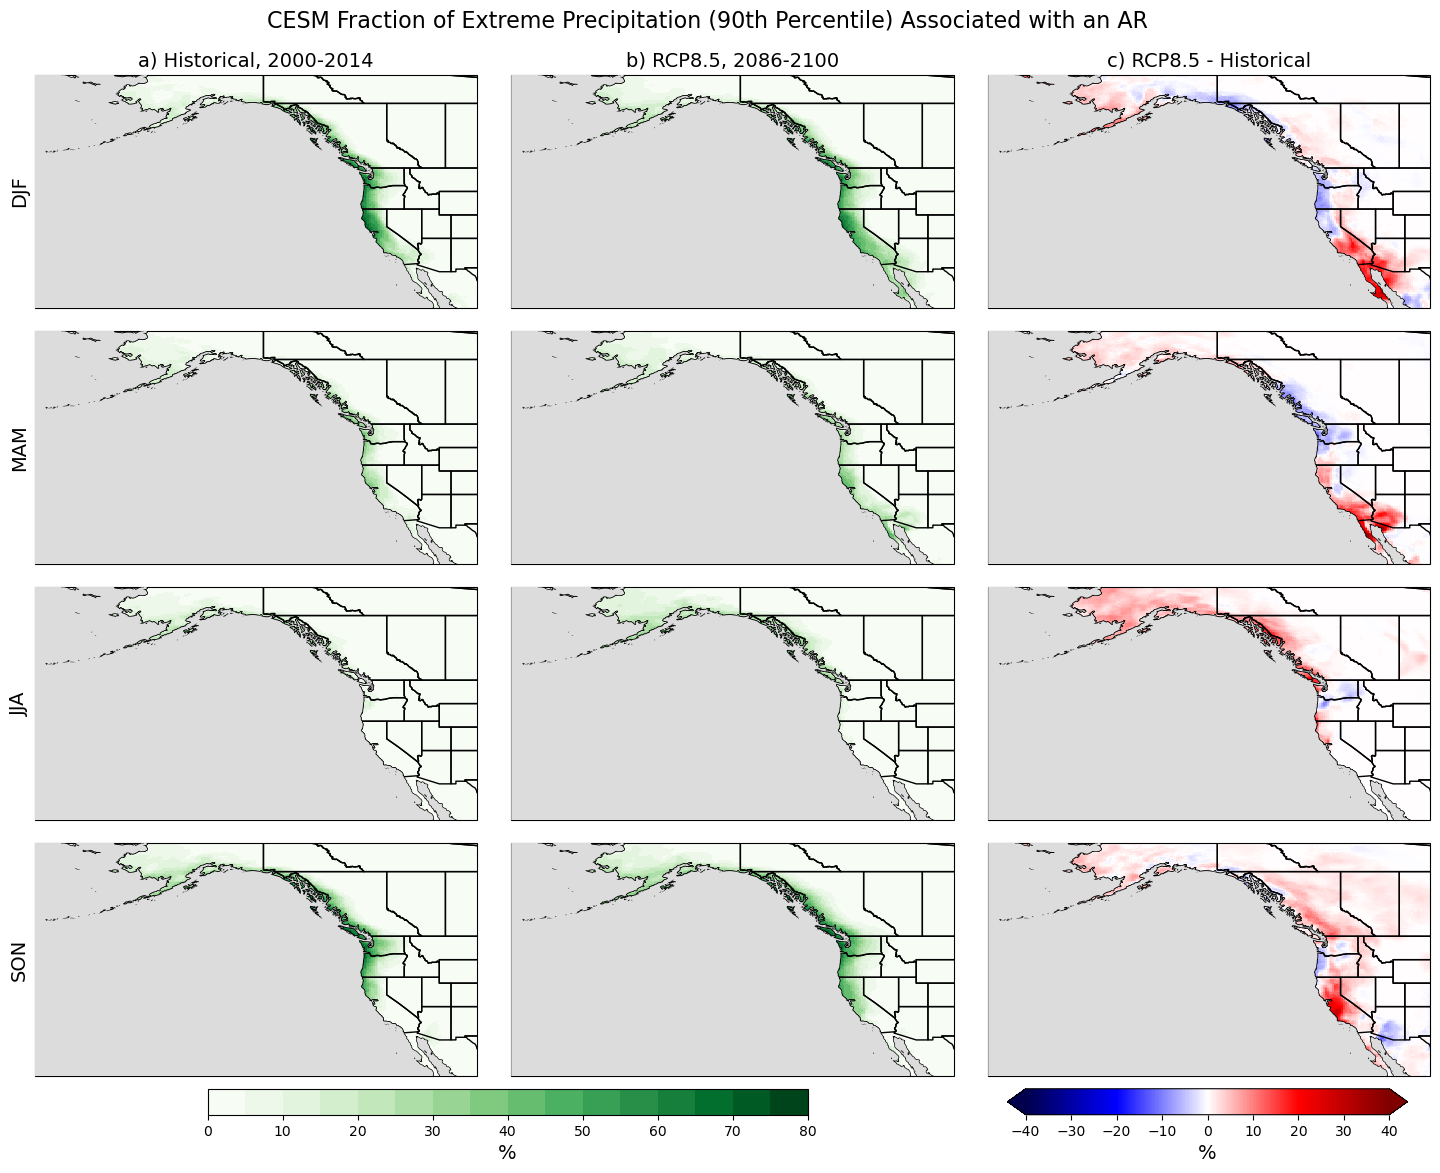

In [95]:
#PEx_AR_frac_byseason_diff = PEx_AR_frac_byseason_rcp85 - PEx_AR_frac_byseason
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

# discrete colormap for absolute plots
cmap=plt.get_cmap('Greens', 16)
vmax = 80

# try changing the hatch color
#plt.rcParams.update({'hatch.color': 'k'})

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(PEx_AR_frac_byseason.sel(season=season), coord=PEx_AR_frac_byseason.lon)
    lat = PEx_AR_frac_byseason.lat
    cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.STATES, zorder=2)
    # optionally add greyed out ocean
    axs[i,0].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])
    axs[i,0].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(PEx_AR_frac_byseason_rcp85.sel(season=season), coord=PEx_AR_frac_byseason_rcp85.lon)
    lat = PEx_AR_frac_byseason_rcp85.lat
    cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.STATES, zorder=2)
    axs[i,1].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,1].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.25, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('%', fontsize=14)

# colormap for diff plots
cmap2 = plt.get_cmap('seismic')
vmin2=-40
vmax2=40

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('c) RCP8.5 - Historical', fontsize=14)
    # significance hatching - need to do this first or plots get cut off
    #lon = PRECT_AR_frac_byseason_diff.lon # need to use original lon (add_cyclic_point adds to the lon dimension)
    #lat = PRECT_AR_frac_byseason_diff.lat
    # need to calculate these quantiles if I want to use significance hatching here
    #axs[i,2].contourf(lon, lat, xr.where((
    #    PRECT_AR_frac_byseason_diff.sel(season=season) <= PRECT_AR_frac_quantiles.sel(season=season, quantile=0.025)) | (
    #    PRECT_AR_frac_byseason_diff.sel(season=season) >= PRECT_AR_frac_quantiles.sel(season=season, quantile=0.975)),
    #    1.0, np.nan).data, 
    #    transform=ccrs.PlateCarree(),
    #    colors='none', levels=[1.0, 1.5],
    #    #hatches=['////'], #another hatch option
    #    hatches=['XXX'],
    #    zorder=10)
    field, lon = add_cyclic_point(PEx_AR_frac_byseason_diff.sel(season=season), coord=PEx_AR_frac_byseason_diff.lon)
    lat = PEx_AR_frac_byseason_diff.lat
    cf = axs[i,2].pcolormesh(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.STATES, zorder=2)
    axs[i,2].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,2].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# colorbar for diff plots
cb2_ax = fig.add_axes([0.65, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('%', fontsize=14)    
    
# add title
fig.suptitle('CESM Fraction of Extreme Precipitation (90th Percentile) Associated with an AR', fontsize=16, y=0.93)

plt.subplots_adjust(wspace=-0.2, hspace=0.1)

#plt.savefig('../figures/toSCP/PEx90_AR_frac_WUS_hist_rcp_diff_byseason.png', bbox_inches='tight', dpi=300)

### Climatological Line Plots

In [274]:
def calc_PEx_AR_time(PEx, AR):
    
    # subset for land only (optional; comment out to use whole domain)
    PEx = PEx.where(landfrac > 0)
    # Compute sum of extreme precipitation amount over space at each timepoint
    PEx_sum = PEx.sum(dim=('lat','lon'))
    
    # PEx overlapping with AR, sum over space
    PEx_AR = PEx.where(AR==1).sum(dim=('lat','lon'))
    
    # proportion of PEx overlapping with AR
    PEx_AR_frac_time = 100*(PEx_AR/PEx_sum)
    
    return(PEx_AR_frac_time)

In [275]:
PEx_AR_frac_time = calc_PEx_AR_time(PEx, AR)
PEx_AR_frac_time_rcp85 = calc_PEx_AR_time(PEx_rcp85, AR_rcp85)

In [276]:
PEx_AR_frac_time

<xarray.DataArray 'PRECT' (time: 46720)>
dask.array<mul, shape=(46720,), dtype=float32, chunksize=(500,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

In [277]:
# mean by month of year
PEx_AR_frac_time_monthofyear = PEx_AR_frac_time.groupby("time.month").mean().persist()
# standard deviation
#PEx_AR_frac_time_monthofyear_std = PEx_AR_frac_time.groupby("time.month").std().persist()

In [73]:
PEx_AR_frac_time_monthofyear

<xarray.DataArray 'PRECT' (month: 12)>
dask.array<stack, shape=(12,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    quantile  float64 0.9
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [278]:
# mean by month of year
PEx_AR_frac_time_monthofyear_rcp85 = PEx_AR_frac_time_rcp85.groupby("time.month").mean().persist()
# standard deviation
#PEx_AR_frac_time_monthofyear_std_rcp85 = PEx_AR_frac_time_rcp85.groupby("time.month").std().persist()

In [279]:
# differences (TO DO: think about how std works here)
PEx_AR_frac_time_monthofyear_diff = PEx_AR_frac_time_monthofyear_rcp85 - PEx_AR_frac_time_monthofyear

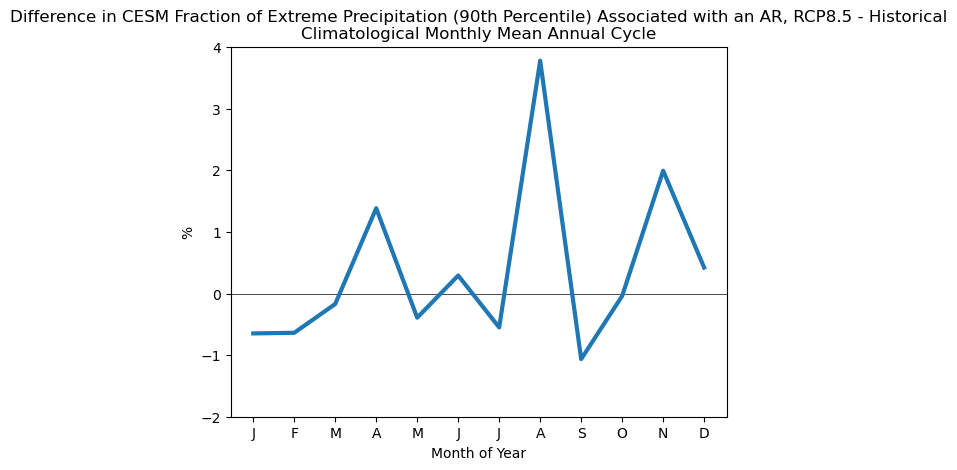

In [282]:
plt.plot(PEx_AR_frac_time_monthofyear_diff.month, PEx_AR_frac_time_monthofyear_diff, linewidth=3, zorder=10)
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.ylim([-2,4])
plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=0.5)
plt.title('Difference in CESM Fraction of Extreme Precipitation (90th Percentile) Associated with an AR, RCP8.5 - Historical\nClimatological Monthly Mean Annual Cycle');

#plt.savefig('../figures/toSCP/PEx90_AR_monthofyear_WUS_CESM_diff_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PEx90_AR_monthofyear_WUS_CESM_diff_unwgt_config.png', bbox_inches='tight')

## Process plots for AR precipitation
### Custom precip colormap from unidata
https://unidata.github.io/python-gallery/examples/Precipitation_Map.html

In [29]:
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap_prec = mcolors.ListedColormap(cmap_data, 'precipitation')
norm_prec = mcolors.BoundaryNorm(clevs, cmap_prec.N)

In [30]:
# testing time indexing
t = '2000-08-21T21'
PRECT_hist.sel(time=t)[0]

<xarray.DataArray 'PRECT' (lat: 170, lon: 225)>
dask.array<getitem, shape=(170, 225), dtype=float32, chunksize=(170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
    time     object 2000-08-21 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

In [31]:
t = '2001-12-21T00'
PRECT_hist.sel(time=t)[0]

<xarray.DataArray 'PRECT' (lat: 170, lon: 225)>
dask.array<getitem, shape=(170, 225), dtype=float32, chunksize=(170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
    time     object 2001-12-21 00:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

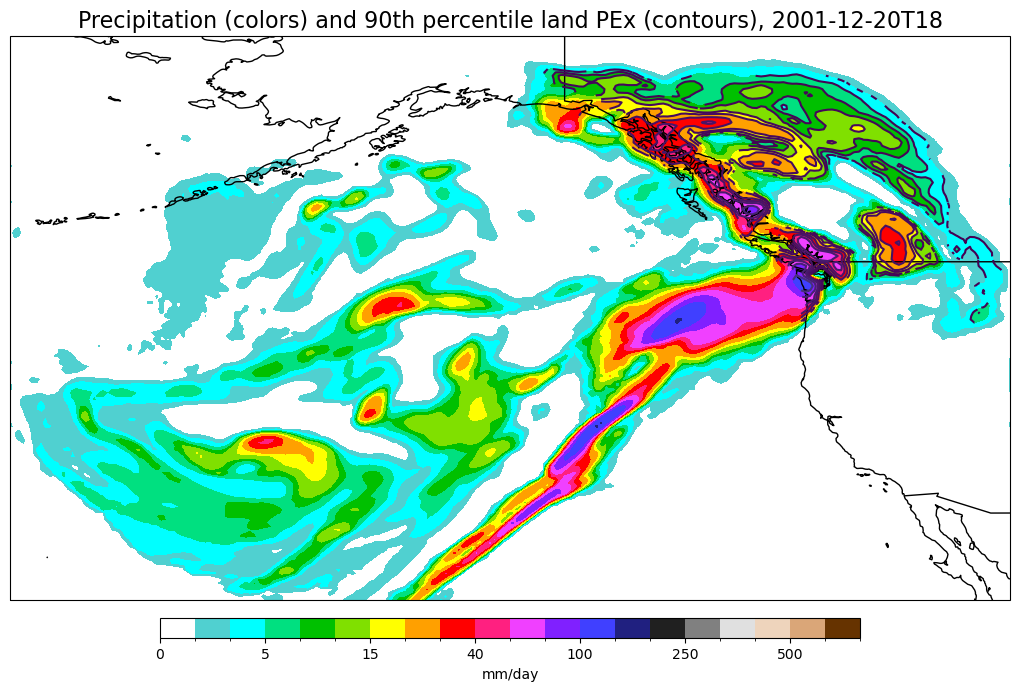

In [46]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # the central_longitude is important when region extends to/beyond longitude 180

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T18'

# PEx contours first (land only)
pfield = PEx.sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_PEx = ax.contour(lon, lat, field, clevs, transform=ccrs.PlateCarree())

# PRECT filled contour second (land & ocean)
pfield = PRECT_hist.sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())
#c_prec = ax.pcolormesh(lon, lat, field, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
ax.set_title('Precipitation (colors) and 90th percentile land PEx (contours), '+t, fontsize=16);
#ax.set_title('90th percentile precipitation, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PRECT_PEx90_CESM_2001-12-20-18.png', bbox_inches='tight')

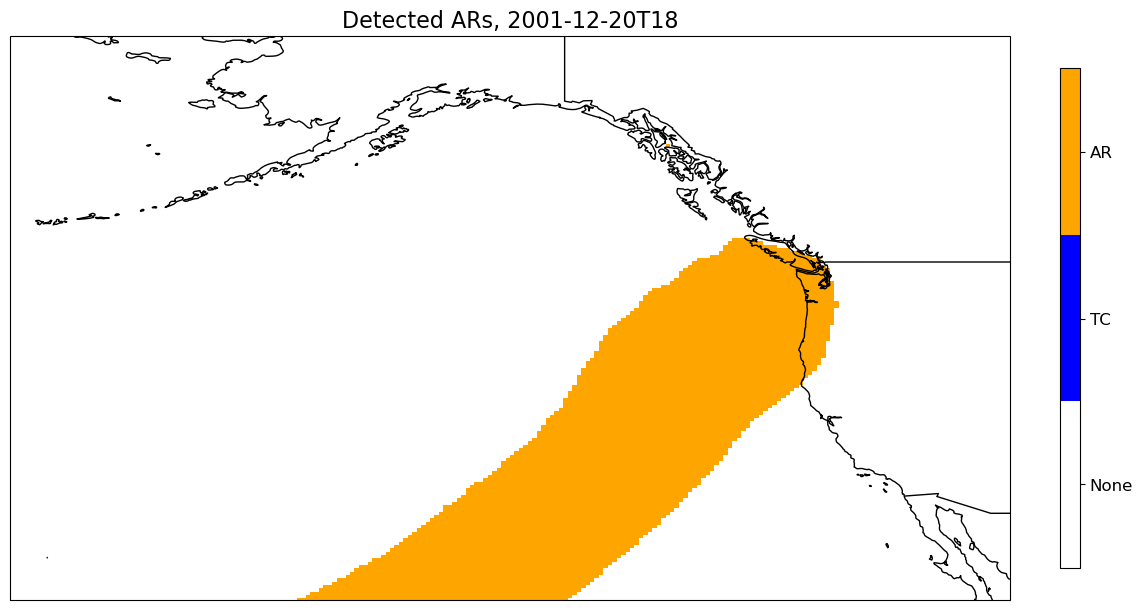

In [14]:
# ARs at the same time index
cmap_all = mcolors.ListedColormap(['w', 'blue', 'orange'])
bounds = [0, 0.99, 1.99, 2.99]
#norm = matplotlib.colors.BoundaryNorm(bounds, cmap_all.N)

fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # the central_longitude is important when region extends to/beyond longitude 180

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T18'

ffield = cnet_hist.sel(time=t)[0]
field, lon = add_cyclic_point(ffield, coord=ffield.lon)
lat = ffield.lat
cf = ax.pcolormesh(lon, lat, field, cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree())

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# colorbar
cbar_ax = fig.add_axes([1.05, 0.25, 0.02, 0.5])
norm_all_cb = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm_all_cb,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

# add title
ax.set_title('Detected ARs, '+t, fontsize=16);

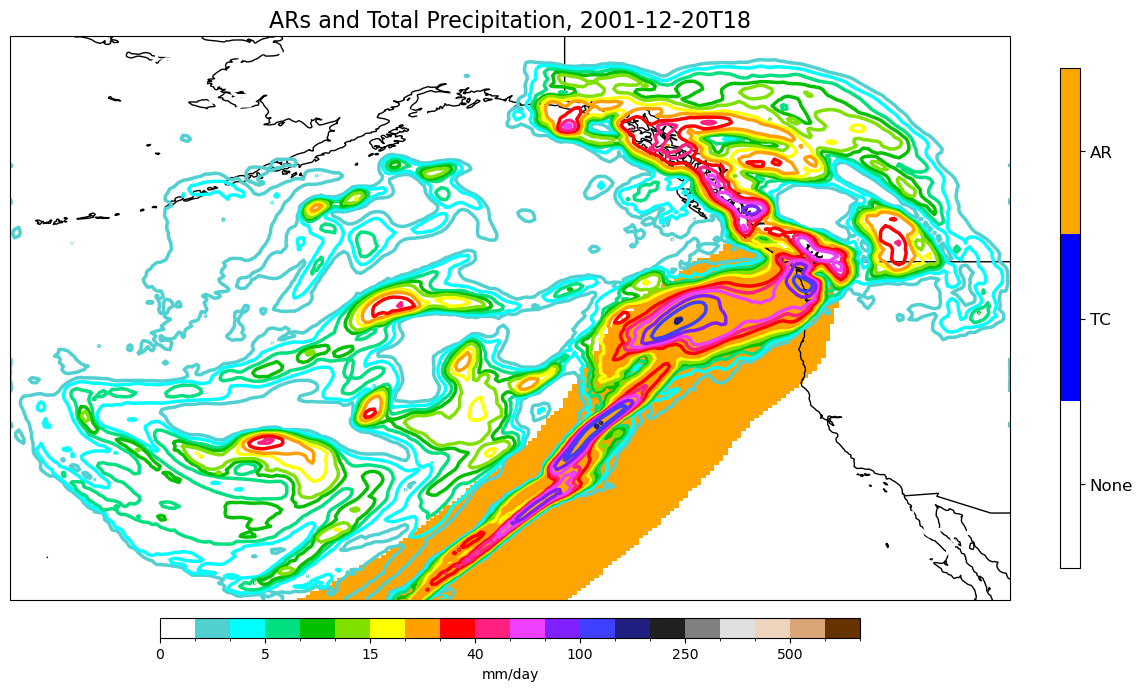

In [53]:
# overlay PRECT, PEx, and AR mask
cmap_all = mcolors.ListedColormap(['w', 'blue', 'orange'])
bounds = [0, 0.99, 1.99, 2.99]

fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # the central_longitude is important when region extends to/beyond longitude 180

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T18'

# AR mask
ffield = cnet_hist.sel(time=t)[0]
field, lon = add_cyclic_point(ffield, coord=ffield.lon)
lat = ffield.lat
cf = ax.pcolormesh(lon, lat, field, cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree())

# PEx contours (land only)
#pfield = PEx.sel(time=t)[0]*1000*86400
#field, lon = add_cyclic_point(pfield, coord=pfield.lon)
#lat = pfield.lat
#c_PEx = ax.contour(lon, lat, field, clevs, transform=ccrs.PlateCarree(), alpha=0.8)
#c_PEx = ax.contour(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree(), alpha=0.8)

# PRECT filled contour (land & ocean)
pfield = PRECT_hist.sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
#cf_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree(), alpha=0.5)

# PRECT contour
ct_prec = ax.contour(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree(), linewidths=2.5)

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# ARs colorbar
cbar_ax = fig.add_axes([1.05, 0.25, 0.02, 0.5])
norm_all_cb = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm_all_cb,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

# precip colorbar - reference above plot
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
#ax.set_title('ARs and 90th percentile precipitation, '+t, fontsize=16);
ax.set_title('ARs and Total Precipitation, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/AR_PRECT_CESM_hist_rcp26_unwgt_2001-12-20-18.png', bbox_inches='tight')

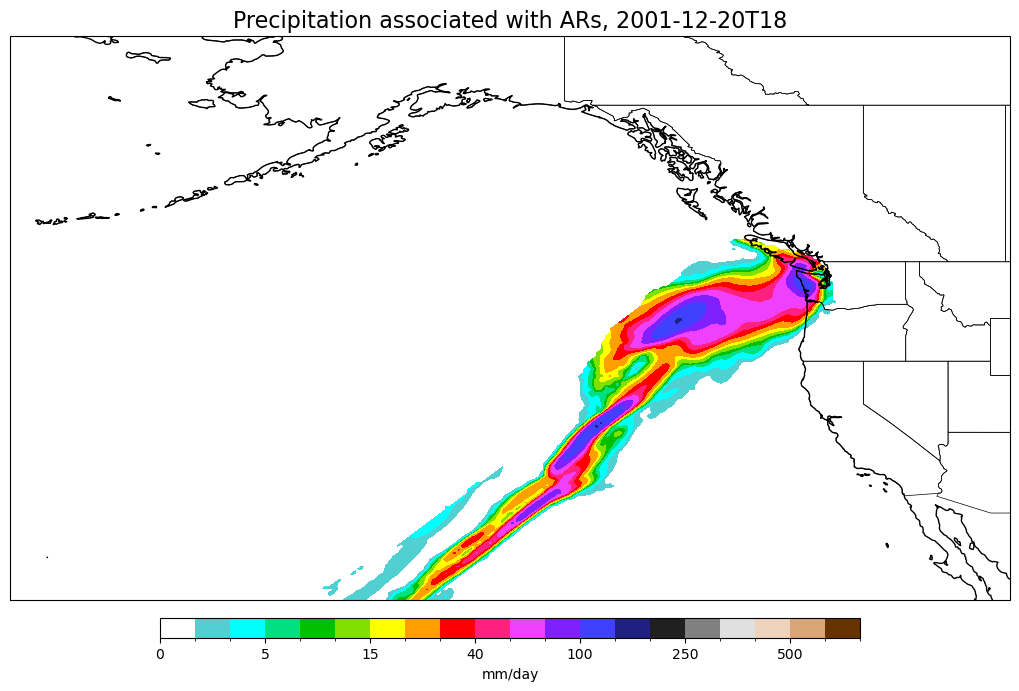

In [65]:
# PRECT_AR at the same time index
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

# select time index
t = '2001-12-20T18'

pfield = PRECT_hist.where(AR==1).sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())
ax.coastlines(zorder=1)
ax.add_feature(cfeature.STATES, zorder=2, linewidth=0.5)

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
ax.set_title('Precipitation associated with ARs, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PRECT_AR_CESM_hist_rcp26_unwgt_2001-12-20-18.png', bbox_inches='tight')

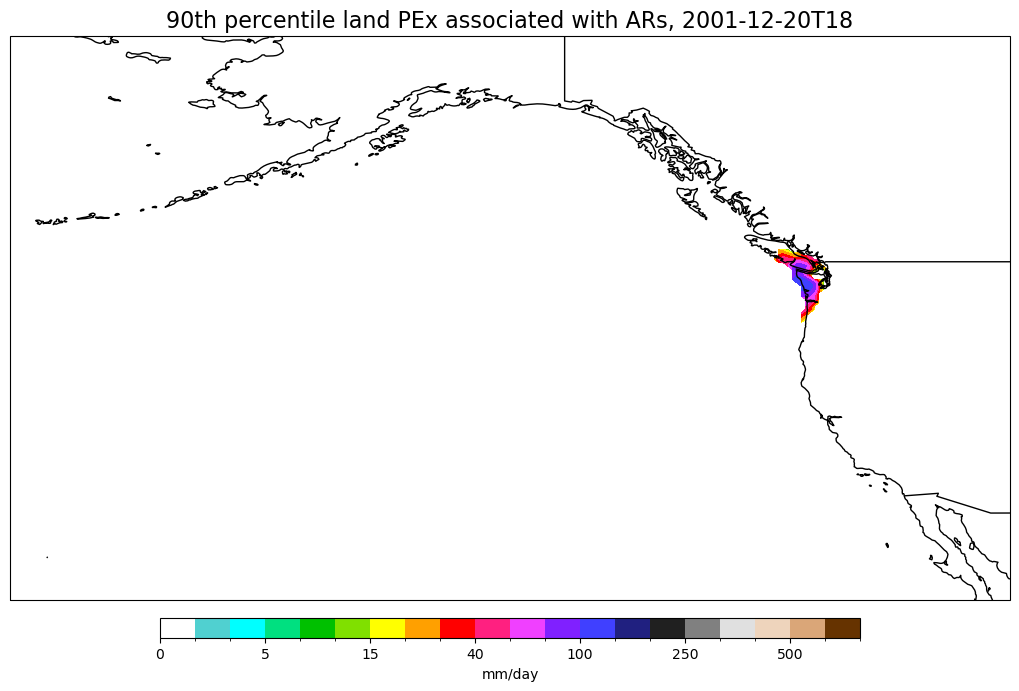

In [54]:
# PEx_AR at the same time index - note land only PEx points
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

# select time index
t = '2001-12-20T18'

pfield = PEx.where(AR==1).sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# extending the spatial range to force the map to plot more (where there is no PEx_AR)
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
ax.set_title('90th percentile land PEx associated with ARs, '+t, fontsize=16);

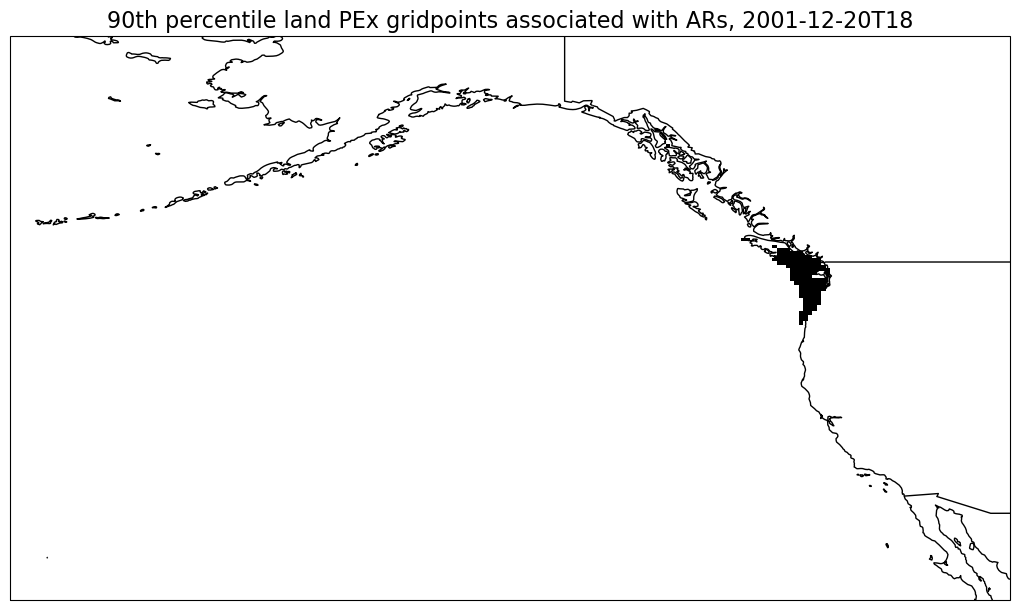

In [55]:
# gridpoints only (no precip info)

fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T18'

pfield = (PEx.where(AR==1).sel(time=t)[0]*1000*86400).notnull()
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.pcolormesh(lon, lat, field, cmap='Greys', transform=ccrs.PlateCarree())

ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add title
ax.set_title('90th percentile land PEx gridpoints associated with ARs, '+t, fontsize=16);

4/9/24: left off here; release some hub memory (how to see what is persisted?) and repeat PR plots

## Probability Ratios

From fronts analysis:\
$PR = (N_P|F/N_F)/(N_P/N)$ where $N$, $N_P$, $N_F$, and $N_P|F$ are the number of time steps, number of time steps with extreme precipitation, number of time steps with fronts, and number of extreme precipitation time steps associated with fronts, i.e., comparing the conditional probability of extreme precipitation during fronts to the climatological probability of extreme precipitation

#### Seasonal PRs

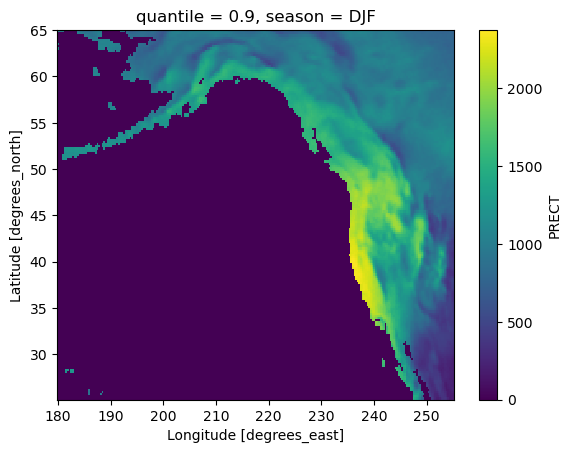

In [42]:
N_P_season = PEx.notnull().groupby('time.season').sum(dim='time')
N_P_season.sel(season='DJF').plot();

In [96]:
def prob_ratio_season(AR, PEx):
    # number of time steps in each season
    N_season = AR.time.groupby('time.season').count()
    
    # number of time steps in each season with extreme precipitation (spatial maps)
    N_P_season = PEx.notnull().groupby('time.season').sum(dim='time')
    
    # number of time steps in each season with ARs (spatial maps)
    N_AR_season = AR.where(AR==1).groupby('time.season').sum(dim='time')
    
    # number of extreme precipitation time steps in each season associated with ARs (spatial maps)
    N_P_AR_season = PEx.where(AR==1).notnull().groupby('time.season').sum(dim='time') 
       
    # probability ratio
    PR_season = (N_P_AR_season/N_AR_season)/(N_P_season/N_season)
    
    return(PR_season)

In [97]:
PR_season = prob_ratio_season(AR, PEx_season)
PR_season_rcp85 = prob_ratio_season(AR_rcp85, PEx_season_rcp85)

In [98]:
PR_season = PR_season.persist()
print(PR_season.max().values)
print(PR_season.min().values)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


10.0
0.0


PR is larger than one when the conditional occurrence exceeds the unconditional occurrence probability.\
PR is close to one when extreme precipitation is not associated with AR occurrence.\
See Fischer & Knutti (2015)

4/7/23: Running out of hub memory (4GB) with this plot

/glade/derecho/scratch/kdagon/tmp/ipykernel_9048/117119008.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greens = plt.cm.get_cmap('Greens', 14)
/glade/derecho/scratch/kdagon/tmp/ipykernel_9048/117119008.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  yellows = plt.cm.get_cmap('YlOrRd', 10)


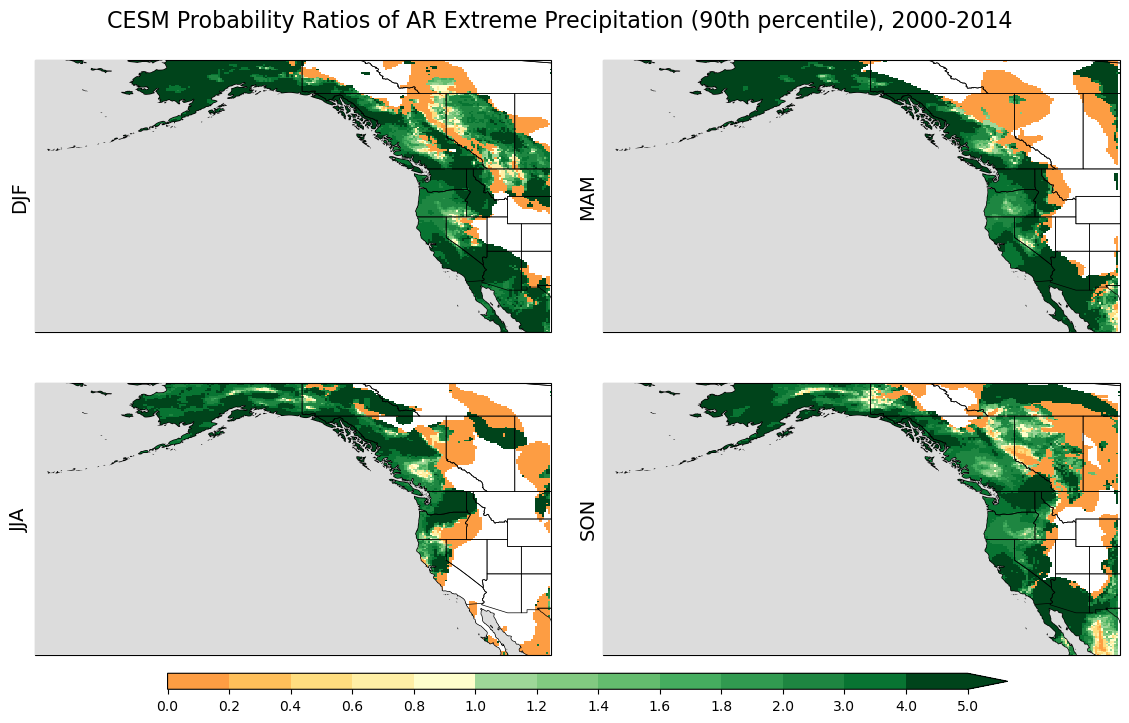

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# using color sampled from Greens and Yellows
greens = plt.cm.get_cmap('Greens', 14)
greens_cmap = greens(range(14))
yellows = plt.cm.get_cmap('YlOrRd', 10)
yellows_cmap = yellows(range(5))
greens_cmap[:5] = np.flip(yellows_cmap, axis=0) # replace first 5 colors with flipped yellows
cmap = mpl.colors.ListedColormap(greens_cmap)
bounds = [0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,3,4,5] # custom bounds sampling close to 1 on either side
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# don't need to set these now?
#vmin=0
#vmax=5

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(PR_season.sel(season=season), coord=PR_season.lon)
    lat = PR_season.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    # add greyed out ocean
    axs[i].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb1_ax = fig.add_axes([0.22, 0.08, 0.6, 0.02])
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max', ticks=bounds)

# add title
#fig.suptitle('CESM Probability Ratios of AR Extreme Precipitation (90th percentile)', fontsize=16, y=0.93)
fig.suptitle('CESM Probability Ratios of AR Extreme Precipitation (90th percentile), 2000-2014', fontsize=16, y=0.93)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/PR90_AR_WUS_CESM_hist_rcp26_byseason_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PR90_AR_WUS_CESM_hist_rcp26_byseason_unwgt_artmip-lons.png', bbox_inches='tight')

In [100]:
%%time
PR_season_rcp85 = PR_season_rcp85.persist()
print(PR_season_rcp85.max().values, PR_season_rcp85.min().values)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


16.52694610778443 0.0
CPU times: user 1min 22s, sys: 2.1 s, total: 1min 24s
Wall time: 3min


5/24/23: Not a problem with current resource request (some dask worker memory spilled to disk)

/glade/derecho/scratch/kdagon/tmp/ipykernel_9048/4075680535.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greens = plt.cm.get_cmap('Greens', 14)
/glade/derecho/scratch/kdagon/tmp/ipykernel_9048/4075680535.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  yellows = plt.cm.get_cmap('YlOrRd', 10)


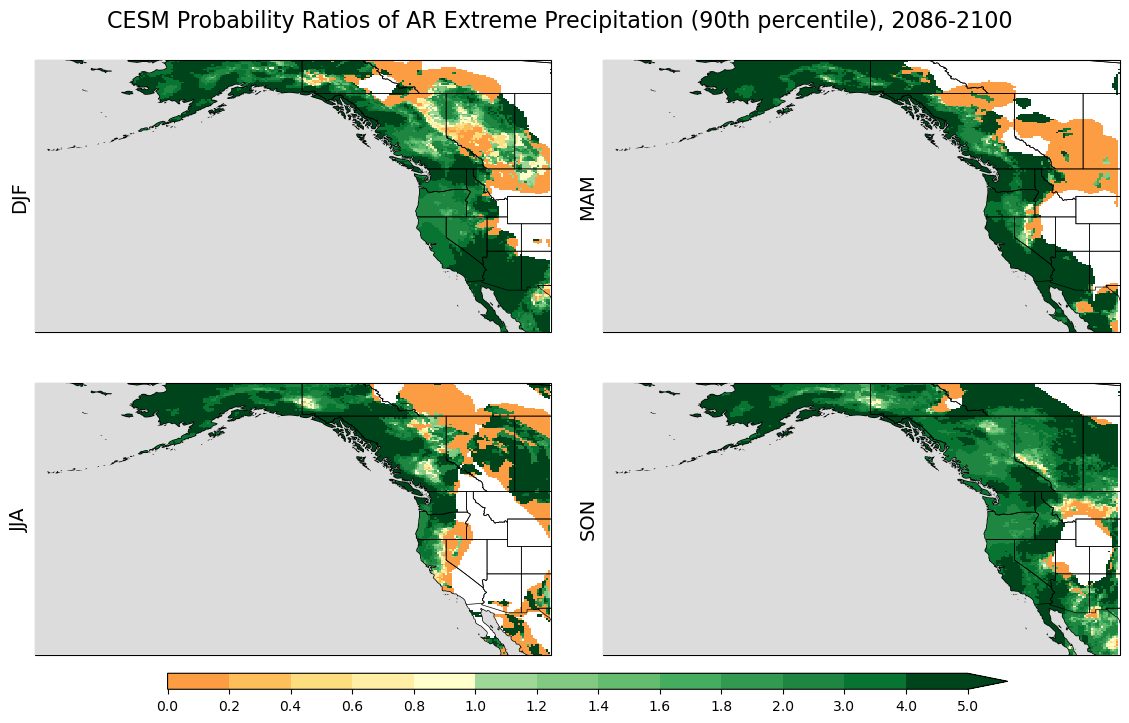

In [101]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# using color sampled from Greens and Yellows
greens = plt.cm.get_cmap('Greens', 14)
greens_cmap = greens(range(14))
yellows = plt.cm.get_cmap('YlOrRd', 10)
yellows_cmap = yellows(range(5))
greens_cmap[:5] = np.flip(yellows_cmap, axis=0) # replace first 5 colors with flipped yellows
cmap = mpl.colors.ListedColormap(greens_cmap)
bounds = [0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,3,4,5] # custom bounds sampling close to 1 on either side
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# don't need to set these now?
#vmin=0
#vmax=5

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(PR_season_rcp85.sel(season=season), coord=PR_season_rcp85.lon)
    lat = PR_season_rcp85.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    # add greyed out ocean
    axs[i].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb1_ax = fig.add_axes([0.22, 0.08, 0.6, 0.02])
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max', ticks=bounds)

# add title
fig.suptitle('CESM Probability Ratios of AR Extreme Precipitation (90th percentile), 2086-2100', fontsize=16, y=0.93)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/PR90_AR_WUS_CESM_rcp85_byseason_unwgt.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/PR90_AR_WUS_CESM_rcp85_byseason_unwgt_config.png', bbox_inches='tight')

### Side-by-side panel plot

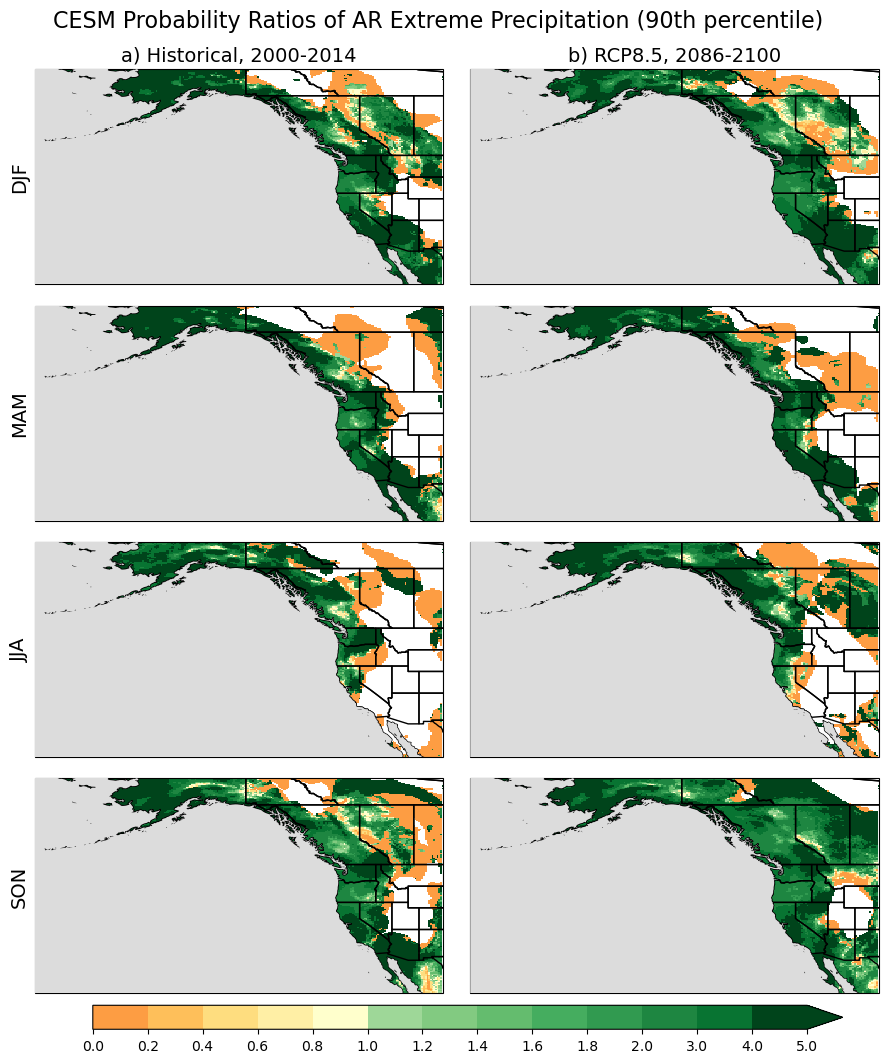

In [50]:
fig, axs = plt.subplots(4, 2, figsize=(15,12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

# using color sampled from Greens and Yellows
greens = plt.get_cmap('Greens', 14)
greens_cmap = greens(range(14))
yellows = plt.get_cmap('YlOrRd', 10)
yellows_cmap = yellows(range(5))
greens_cmap[:5] = np.flip(yellows_cmap, axis=0) # replace first 5 colors with flipped yellows
cmap = mpl.colors.ListedColormap(greens_cmap)
bounds = [0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,3,4,5] # custom bounds sampling close to 1 on either side
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# don't need these?
#vmin=0
#vmax=5

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(PR_season.sel(season=season), coord=PR_season.lon)
    lat = PR_season.lat
    cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.STATES, zorder=2)
    # add greyed out ocean
    axs[i,0].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])
    axs[i,0].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(PR_season_rcp85.sel(season=season), coord=PR_season_rcp85.lon)
    lat = PR_season_rcp85.lat
    cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.STATES, zorder=2)
    axs[i,1].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i,1].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.27, 0.08, 0.5, 0.02])
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max', ticks=bounds)

# add title
fig.suptitle('CESM Probability Ratios of AR Extreme Precipitation (90th percentile)', fontsize=16, y=0.93)

plt.subplots_adjust(wspace=-0.4, hspace=0.1)

#plt.savefig('../figures/toSCP/PR90_AR_WUS_hist_rcp_byseason.png', bbox_inches='tight', dpi=300)

In [39]:
client.close()
cluster.close()